In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)

## Introduction

A computer science research group at UBC (led by Frank Woods), set up a Minecraft server and collected data on the types of people in the server as well as how they play the game. Minecraft is a open-world sandbox game that players can freely explore, build structures, and interact with others in the world. To help target recruitment efforts, our group has used the "players" dataset to answer the broad question: "Which 'kinds' of players are most likely to contribute a large amount of data?" The specific question we have chosen is: **"Can player age predict the amount of time a player spends playing in the server in the players.csv dataset?"** The amount of time spent playing in the server represents how much data they contribute to the study, and being able to predict what types of players will contribute more data can help the research team recruit new players effectively.

The "players" dataset, consisting of 196 observations (players) and 7 variables, consists of characteristics of players in the Minecraft server:

- experience (chr)
  - Player's experience level, consisting of: Amateur, Beginner, Regular, Veteran, Pro.
- subscribe (lgl)
  - Whether or not the player is subscribed to the game newsletter, can be TRUE or FALSE.
- hashedEmail (chr)
  - Player's hashed email.
- played_hours (dbl)
  - Number of hours player has played in this server.
  - A potential issue with the way this data was collected is that it only represents the number of hours played in this specific server, and isn't representative of their total number of hours played, which can lead to an inaccurate representation of their commitment/experience.
- name (chr)
  - Player's first name.
- gender (chr)
  - Player's gender, consisting of: Male, Female, Non-binary, Two-spirited, Agender, Prefer not to say, Other.
  - The "Prefer not to say" values pose a potential issue when deciding whether or to treat them as NA values or as their own category.
- Age (dbl)
  - Player's age in years.
  - This column contains some NA values, which need to be removed when performing data manipulation and analysis.

## Methods and Results

In [ ]:
# Load players dataset into notebook
players <- read_csv("https://raw.githubusercontent.com/owenkotler/dsci_100_project_group_40/refs/heads/main/players.csv")
head(players)

In [ ]:
# Wrangle data so there are no values with 'NA'
players <- players |>
  filter(!is.na(Age)) |>
  filter(!is.na(played_hours))

The data is in tidy format, as each row depicts a single observation (a unique player), each column represents a single variable (age, name, etc.), and each cell contains a single value.

In [ ]:
# Selecting for variables of interest
players_data <- players |>
    select(played_hours, Age)

In [ ]:
# Calculating summary statistics for variables of interest
played_hours_summary <- players |>
    summarise(
        played_hours_mean = mean(played_hours),
        played_hours_median = median(played_hours),
        played_hours_range = max(played_hours) - min(played_hours),
        played_hours_sd = sd(played_hours),
        played_hours_Q1 = quantile(played_hours, 0.25),
        played_hours_Q2 = quantile(played_hours, 0.75)) |>
        round(2)
played_hours_summary

age_summary <- players |>
    summarise(
        age_mean = mean(Age),
        age_median = median(Age),
        age_range = max(Age) - min(Age),
        age_sd = sd(Age),
        age_Q1 = quantile(Age, 0.25),
        age_Q2 = quantile(Age, 0.75)) |>
        round(2)
age_summary


### Figure 1: Scatterplot showing the relationship between Age and Hours Played with trend line

In [ ]:
ggplot(players, aes(x=Age, y=played_hours)) +
    geom_point(alpha = 0.4) +
    geom_smooth(aes(colour = "Linear Trend"), method = "lm", se = FALSE) +
    scale_colour_manual(values = c("Linear Trend" = "blue"), name = "Legend") +
    labs(title = "Relationship Between Age and Hours Played",
         x = "Player Age (years)",
         y = "Time Played (hours)")

### Figure 2: Distribution of Player Ages

In [ ]:
ggplot(players_data, aes(x = Age)) +
  geom_histogram(binwidth = 3) +
  labs(title = "Distribution of Player Ages", x = "Age (years)", y = "Number of Players")

### Figure 3: Distribution of Weekly Hours Played

In [ ]:
ggplot(players_data, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(title = "Distribution of Played Hours", x = "Time played (hours)", y = "Number of Players")

As can be seen from Figure 3 and the summary statistics, most players play a very low amount of hours, with the median being 0.1 hours and the first quartile being 0 hours. In addition to this, the vast majority of players are around 19-20 years of age, as can be seen from Figure 2. These factors combined cause the majority of data points in Figure 1 to cluster in one area, making it difficult to see a clear trend. There is a slight negative relationship between Age and played hours, however this relationship is weak due to the high variability in hours played among younger players and the scarcity of data for older players.

### Figure 4: Average daily time spent playing games per capita in the United States in 2024, by age group
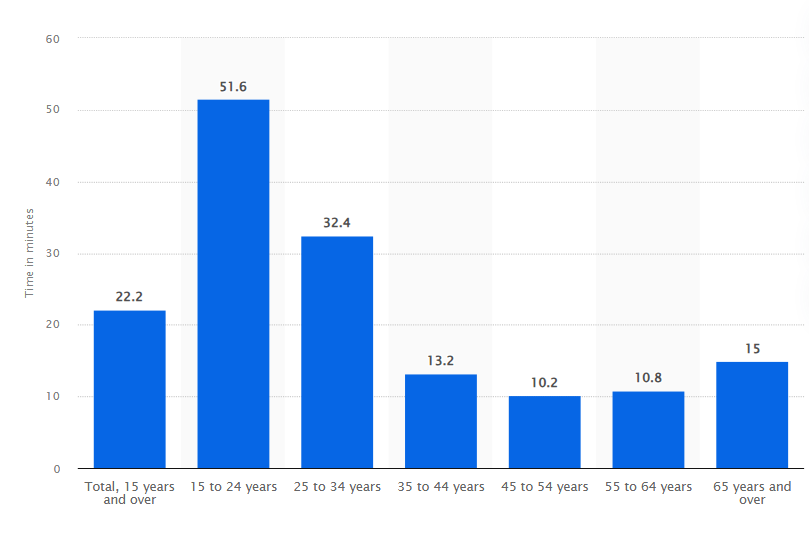
Source: Bureau of Labor Statistics (2024)

Figure 4 shows that there is a strong negative relationship between daily time spent playing video games and age. Because Minecraft is a video game, it would be reasonable to assume that amount of time spent playing Minecraft vs. Age should show a similar trend. So although the players dataset does not show a strong relationship between time played and age due to it being a small dataset, age can be chosen as a good predictor variable of time spent playing Minecraft.

We will be using "Age" as the predictor variable and "played_hours" as the response variable. A k-nearest neighbours (KNN) regression model can be used to address our question because our response variable is quantitative. We will be splitting the dataset into 70% training and 30% testing datasets and using 5-fold cross-validation to select the best k value. Steps for analysis can be seen as comments throughout the code.

In [ ]:
# Splitting dataset into training and testing
set.seed(123)
players_split <- initial_split(players_data, prop = 0.7, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [ ]:
# Training, evaluating, and tuning the model
set.seed(143)
players_recipe <- recipe(played_hours ~ Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)    

gridvals <- tibble (neighbors = seq(from = 1, to = 15, by = 1))

players_results <- players_wkflw |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))

kmin <- players_min |> pull (neighbors)

kmin

# kmin is the value of k that results in the lowest RMSE


In [ ]:
# Evaluate on the test set
set.seed(123)
players_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec2) |>
    fit(data = players_train)

players_preds <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_summary <- players_preds |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter (.metric == "rmse")

players_summary

# results in RMSPE on test data

### Figure 5: Comparison of Actual and Predicted Hours Played vs Age

In [ ]:
players_plot <- players_preds |>
    ggplot(aes(x=Age, y = played_hours)) +
    geom_point(aes(y = played_hours, color = "Actual"), alpha = 0.5) +
    geom_line(aes(y = .pred, color = "Predicted"), size = 1) +
    labs(x = "Age (years)", y = "Time played (hours)", title = "Time Played vs. Age, Coloured by Actual and Predicted",
        color = "Legend")
    
players_plot

Figure 5

## Discussion
summarize what you found

discuss whether this is what you expected to find

discuss what impact could such findings have

discuss what future questions could this lead to

### Summary of Findings

Based on Figure 1, we can observe that there is 

## References

Bureau of Labor Statistics. (September 8, 2025). Average daily time spent playing games per capita in the United 
    States in 2024, by age group (in minutes) [Graph]. In Statista. Retrieved December 01, 2025, from 
    https://www.statista.com/statistics/789835/average-daily-time-playing-games-us-by-age/

Mojang Studios (2011)
https://www.minecraft.net/